In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [2]:
import anchors
import statsmodels
from scipy import stats

def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots




## Data summary
 

In [3]:
reads = pd.read_excel('../../Data/Reads/Wilen/supplementary_reads_v1.xlsx', sheet_name= 'VeroE6 SARS-2 genomewide reads')
reads

,Construct Barcode,pDNA,Cas9-v1 D10 Mock,Cas9-v1 D10 Lo-MOI,Cas9-v1 D10 Hi-MOI,Cas9-v2 D5 Mock,Cas9-v2 D10 5e6 Hi-MOI,Cas9-v2 D5 5e6 Hi-MOI,Cas9-v2 D2 5e6 Hi-MOI,Cas9-v2 D5 2.5e6 Lo-MOI,Cas9-v2 D5 2.5e6 Hi-MOI
0,TGATAGTAGGATAATAGCGA,67,185,240,87,126,54,12,19,28,149
1,AGGGTTGTAGTAGTCCGTAA,48,189,110,50,137,32,32,13,114,26
2,GCCTTCTATGAGGTCGAAGG,66,311,107,79,241,122,166,186,128,211
3,GATGGTGTAGAGAGTAGTGG,84,403,235,179,437,139,101,96,135,213
4,CCCTCAACAACCTACTATCG,68,316,86,116,414,114,71,243,98,282
...,...,...,...,...,...,...,...,...,...,...,...
84958,ATGGTACGTCGCGAACGATG,64,223,151,158,320,114,133,192,89,267
84959,CGGCGCCAATCGACGTGTCG,44,170,95,51,297,57,103,35,131,182
84960,GCCTCGACCGTGCGACGATA,70,399,28,115,392,114,123,77,113,122
84961,GGCTTAACGCCGCGTACAAG,37,168,36,17,265,70,112,142,133,203


In [4]:
# Gene Annotations
chip = pd.read_csv('../../Data/Interim/Goujon/VeroE6/CP0070_Chlorocebus_sabeus_remapped.chip', sep ='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads = chip_reads.rename(columns={'Gene':'Gene Symbol'})

In [5]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
lognorms
# lognorms = lognorms.rename(columns={'count_lognorm':'pDNA_lognorm'})

,Construct Barcode,Gene Symbol,pDNA_lognorm,Cas9-v1 D10 Mock_lognorm,Cas9-v1 D10 Lo-MOI_lognorm,Cas9-v1 D10 Hi-MOI_lognorm,Cas9-v2 D5 Mock_lognorm,Cas9-v2 D10 5e6 Hi-MOI_lognorm,Cas9-v2 D5 5e6 Hi-MOI_lognorm,Cas9-v2 D2 5e6 Hi-MOI_lognorm,Cas9-v2 D5 2.5e6 Lo-MOI_lognorm,Cas9-v2 D5 2.5e6 Hi-MOI_lognorm
0,TGATAGTAGGATAATAGCGA,ND1,3.687789,3.548332,4.949978,4.047260,2.874466,3.278934,1.608968,1.857887,2.395908,4.246221
1,AGGGTTGTAGTAGTCCGTAA,ND1,3.250310,3.576581,3.878580,3.311343,2.979335,2.622775,2.693222,1.483308,4.198246,2.048592
2,GCCTTCTATGAGGTCGAAGG,ND1,3.667789,4.246875,3.841435,3.916907,3.713006,4.369465,4.875926,4.738501,4.356734,4.725638
3,GATGGTGTAGAGAGTAGTGG,ND1,3.991180,4.603288,4.920597,5.042570,4.521400,4.549107,4.190377,3.834101,4.429894,4.738737
4,CCCTCAACAACCTACTATCG,ND2,3.707515,4.268682,3.550602,4.440315,4.446883,4.276507,3.714922,5.111422,3.992840,5.130296
...,...,...,...,...,...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_144,3.626938,3.796683,4.308744,4.868341,4.094626,4.276507,4.568309,4.782615,3.862999,5.053753
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_163,3.138497,3.437182,3.682481,3.337060,3.993542,3.349092,4.217131,2.544755,4.388544,4.520996
88868,GCCTCGACCGTGCGACGATA,NO_SITE_193,3.746177,4.589492,2.166536,4.428402,4.371814,4.276507,4.460477,3.540672,4.186230,3.974516
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_47,2.919185,3.421693,2.455866,2.012621,3.839967,3.618949,4.331739,4.365739,4.409367,4.672022


## Quality Control
### Population Distributions

In [6]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc

# Average across Cas9-v2 columns 
Cas9v2_data_cols = [col for col in pDNA_lfc.columns if 'Cas9-v2' in col]
Cas9v2_cols = ['Construct Barcode', 'Gene Symbol']+ Cas9v2_data_cols
Cas9v2_df = pDNA_lfc.copy()[Cas9v2_cols]
Cas9v2_df

# Replace spaces with '_' for following functions
new_col_list=['Construct Barcode', 'Gene Symbol']

for col in Cas9v2_data_cols:
    new_col = col.replace(' ','_')
    new_col_list.append(new_col)

Cas9v2_df.columns = new_col_list 
Cas9v2_df

,Construct Barcode,Gene Symbol,Cas9-v2_D5_Mock_lfc,Cas9-v2_D10_5e6_Hi-MOI_lfc,Cas9-v2_D5_5e6_Hi-MOI_lfc,Cas9-v2_D2_5e6_Hi-MOI_lfc,Cas9-v2_D5_2.5e6_Lo-MOI_lfc,Cas9-v2_D5_2.5e6_Hi-MOI_lfc
0,TGATAGTAGGATAATAGCGA,ND1,-0.813323,-0.408855,-2.078821,-1.829902,-1.291881,0.558432
1,AGGGTTGTAGTAGTCCGTAA,ND1,-0.270975,-0.627535,-0.557088,-1.767002,0.947936,-1.201719
2,GCCTTCTATGAGGTCGAAGG,ND1,0.045217,0.701676,1.208137,1.070712,0.688945,1.057849
3,GATGGTGTAGAGAGTAGTGG,ND1,0.530220,0.557927,0.199197,-0.157079,0.438714,0.747557
4,CCCTCAACAACCTACTATCG,ND2,0.739368,0.568992,0.007406,1.403906,0.285325,1.422781
...,...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_144,0.467688,0.649569,0.941371,1.155677,0.236060,1.426815
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_163,0.855045,0.210595,1.078634,-0.593742,1.250047,1.382499
88868,GCCTCGACCGTGCGACGATA,NO_SITE_193,0.625637,0.530330,0.714300,-0.205504,0.440054,0.228340
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_47,0.920782,0.699764,1.412553,1.446553,1.490182,1.752837


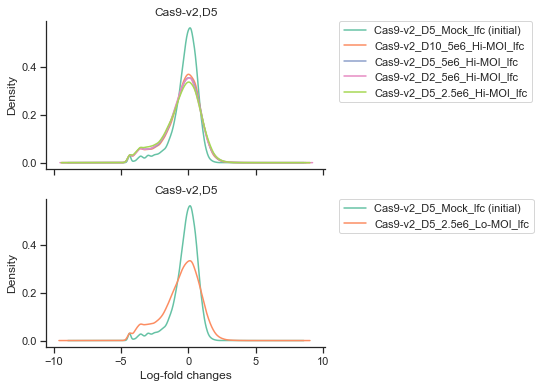

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0
cols=[]
mock_col = [col for col in Cas9v2_df.columns if 'Mock' in col]
hi_MOI_cols = mock_col+ [col for col in Cas9v2_df.columns if 'Hi-MOI' in col]
cols.append(hi_MOI_cols)
lo_MOI_cols = mock_col+ [col for col in Cas9v2_df.columns if 'Lo-MOI' in col]
cols.append(lo_MOI_cols)

for k,c in enumerate(cols): # k = sub-list index, c = list of columns in sub-list
    for l, c1 in enumerate(c):
        if 'Mock' in c1:
            label1 = c1 + ' (initial)'#'Initial population'
        else:
            label1 = c1 #'Resistant population-'+str(l)
        Cas9v2_df[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c[0].split('_')[:2])
    t = ax[i].set_title(title)
    i+=1
    
fig.savefig('../../Figures/Wilen_Vero_population_distributions.png', bbox_inches="tight")

### Distributions of control sets 

In [8]:
# NO_SITE controls -> default controls 
controls = fns.get_controls(Cas9v2_df, control_name=['NO_SITE'])

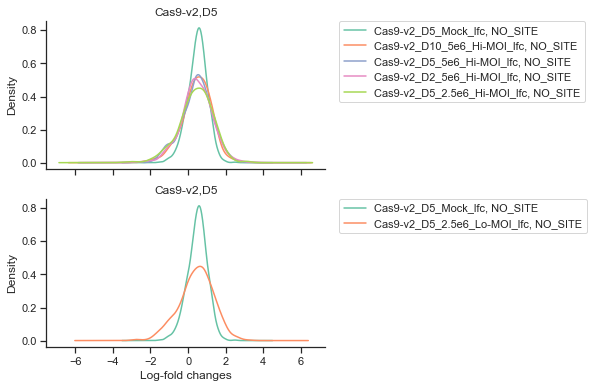

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0

for k,c in enumerate(cols): # k = sub-list index, c = list of columns in sub-list
    for l, c1 in enumerate(c):
        if l==0:
            label1 = c1 + ', NO_SITE'#'Initial population, NO_SITE'
        else:
            label1 = c1 + ', NO_SITE' #'Resistant population-'+str(l) + ', NO_SITE'
        controls[c1].plot(kind='kde',color=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c[0].split('_')[:2])
    t = ax[i].set_title(title)
    i+=1

fig.savefig('../../Figures/Wilen_Vero_control_distributions.png', bbox_inches="tight")

### ROC_AUC

Text(0, 0.5, 'True Positive Rate (essential)')

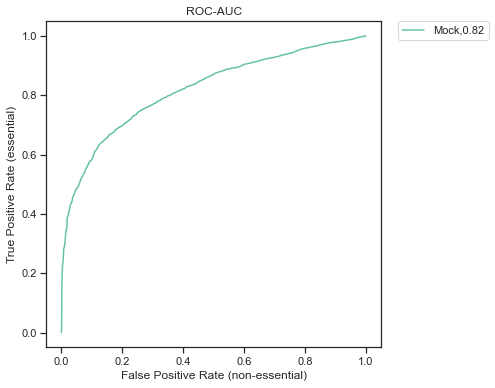

In [10]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

roc_auc, roc_df = pool.get_roc_aucs(Cas9v2_df, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=mock_col)

fig,ax=plt.subplots(figsize=(6,6))
ax=sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Mock,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [11]:
lfc_df = Cas9v2_df.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Cas9-v2_D5_Mock_lfc,Cas9-v2_D10_5e6_Hi-MOI_lfc,Cas9-v2_D5_5e6_Hi-MOI_lfc,Cas9-v2_D2_5e6_Hi-MOI_lfc,Cas9-v2_D5_2.5e6_Lo-MOI_lfc,Cas9-v2_D5_2.5e6_Hi-MOI_lfc
0,TGATAGTAGGATAATAGCGA,-0.813323,-0.408855,-2.078821,-1.829902,-1.291881,0.558432
1,AGGGTTGTAGTAGTCCGTAA,-0.270975,-0.627535,-0.557088,-1.767002,0.947936,-1.201719
2,GCCTTCTATGAGGTCGAAGG,0.045217,0.701676,1.208137,1.070712,0.688945,1.057849
3,GATGGTGTAGAGAGTAGTGG,0.530220,0.557927,0.199197,-0.157079,0.438714,0.747557
4,CCCTCAACAACCTACTATCG,0.739368,0.568992,0.007406,1.403906,0.285325,1.422781
...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,0.467688,0.649569,0.941371,1.155677,0.236060,1.426815
88867,CGGCGCCAATCGACGTGTCG,0.855045,0.210595,1.078634,-0.593742,1.250047,1.382499
88868,GCCTCGACCGTGCGACGATA,0.625637,0.530330,0.714300,-0.205504,0.440054,0.228340
88869,GGCTTAACGCCGCGTACAAG,0.920782,0.699764,1.412553,1.446553,1.490182,1.752837


In [12]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, cols)
residuals_lfcs


                      modified          unperturbed
0   Cas9-v2_D10_5e6_Hi-MOI_lfc  Cas9-v2_D5_Mock_lfc
1    Cas9-v2_D5_5e6_Hi-MOI_lfc  Cas9-v2_D5_Mock_lfc
2    Cas9-v2_D2_5e6_Hi-MOI_lfc  Cas9-v2_D5_Mock_lfc
3  Cas9-v2_D5_2.5e6_Hi-MOI_lfc  Cas9-v2_D5_Mock_lfc
4  Cas9-v2_D5_2.5e6_Lo-MOI_lfc  Cas9-v2_D5_Mock_lfc


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,TGATAGTAGGATAATAGCGA,Cas9-v2_D10_5e6_Hi-MOI_lfc,0.574689,0.609333,Cas9-v2_D5_Mock_lfc,-0.408855,-0.813323
1,TGATAGTAGGATAATAGCGA,Cas9-v2_D5_5e6_Hi-MOI_lfc,-1.055835,-1.083755,Cas9-v2_D5_Mock_lfc,-2.078821,-0.813323
2,TGATAGTAGGATAATAGCGA,Cas9-v2_D2_5e6_Hi-MOI_lfc,-0.789076,-0.811506,Cas9-v2_D5_Mock_lfc,-1.829902,-0.813323
3,TGATAGTAGGATAATAGCGA,Cas9-v2_D5_2.5e6_Hi-MOI_lfc,1.578446,1.534477,Cas9-v2_D5_Mock_lfc,0.558432,-0.813323
4,TGATAGTAGGATAATAGCGA,Cas9-v2_D5_2.5e6_Lo-MOI_lfc,-0.252590,-0.239999,Cas9-v2_D5_Mock_lfc,-1.291881,-0.813323
...,...,...,...,...,...,...,...
424810,TAGCGAACACGATTACGCGT,Cas9-v2_D10_5e6_Hi-MOI_lfc,0.363703,0.385628,Cas9-v2_D5_Mock_lfc,0.046941,-0.088707
424811,TAGCGAACACGATTACGCGT,Cas9-v2_D5_5e6_Hi-MOI_lfc,-1.063087,-1.091199,Cas9-v2_D5_Mock_lfc,-1.387870,-0.088707
424812,TAGCGAACACGATTACGCGT,Cas9-v2_D2_5e6_Hi-MOI_lfc,0.483398,0.497139,Cas9-v2_D5_Mock_lfc,0.149760,-0.088707
424813,TAGCGAACACGATTACGCGT,Cas9-v2_D5_2.5e6_Hi-MOI_lfc,-1.042361,-1.013325,Cas9-v2_D5_Mock_lfc,-1.425507,-0.088707


In [13]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene']], pseudogene_size=4, gene_col='Gene', control_regex=['NO_SITE'])
guide_mapping = guide_mapping.rename(columns={'Gene':'Gene Symbol'})


In [14]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Cas9-v2_D10_5e6_Hi-MOI_lfc,A1BG,4,-0.448237,0.403122,-1.223387,0.221184,0.972373
1,Cas9-v2_D10_5e6_Hi-MOI_lfc,A1CF,4,-0.086505,0.212519,-0.095473,0.923939,0.999304
2,Cas9-v2_D10_5e6_Hi-MOI_lfc,A2ML1,4,-0.184050,-0.479658,1.024048,0.305813,0.989067
3,Cas9-v2_D10_5e6_Hi-MOI_lfc,A3GALT2,4,0.646973,0.551416,0.785460,0.432184,0.996455
4,Cas9-v2_D10_5e6_Hi-MOI_lfc,A4GALT,4,1.000290,0.515713,1.607726,0.107895,0.885010
...,...,...,...,...,...,...,...,...
112745,Cas9-v2_D5_5e6_Hi-MOI_lfc,ZYG11A,4,-0.894369,-0.485964,-0.355059,0.722546,0.998503
112746,Cas9-v2_D5_5e6_Hi-MOI_lfc,ZYG11B,4,-0.578563,-0.322213,-0.057091,0.954473,0.998503
112747,Cas9-v2_D5_5e6_Hi-MOI_lfc,ZYX,4,0.045130,0.053140,0.509708,0.610256,0.998503
112748,Cas9-v2_D5_5e6_Hi-MOI_lfc,ZZEF1,4,-0.298979,0.038549,-0.181533,0.855949,0.998503


In [15]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Cas9-v2_D5_2.5e6_Hi-MOI_lfc', 'Cas9-v2_D10_5e6_Hi-MOI_lfc', 'Cas9-v2_D2_5e6_Hi-MOI_lfc', 'Cas9-v2_D5_2.5e6_Lo-MOI_lfc', 'Cas9-v2_D5_5e6_Hi-MOI_lfc']
Cas9-v2_D5_2.5e6_Hi-MOI_lfc
Cas9-v2_D10_5e6_Hi-MOI_lfc
Cas9-v2_D2_5e6_Hi-MOI_lfc
Cas9-v2_D5_2.5e6_Lo-MOI_lfc
Cas9-v2_D5_5e6_Hi-MOI_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAACTCAAAGAT,SET,Cas9-v2_D10_5e6_Hi-MOI_lfc,0.417325,0.442483,Cas9-v2_D5_Mock_lfc,-0.352259,-0.606141
1,AAAAAAAAAAACTCAAAGAT,SET,Cas9-v2_D5_5e6_Hi-MOI_lfc,-0.823806,-0.845590,Cas9-v2_D5_Mock_lfc,-1.645668,-0.606141
2,AAAAAAAAAAACTCAAAGAT,SET,Cas9-v2_D2_5e6_Hi-MOI_lfc,-0.807834,-0.830797,Cas9-v2_D5_Mock_lfc,-1.645668,-0.606141
3,AAAAAAAAAAACTCAAAGAT,SET,Cas9-v2_D5_2.5e6_Hi-MOI_lfc,-0.812451,-0.789820,Cas9-v2_D5_Mock_lfc,-1.645668,-0.606141
4,AAAAAAAAAAACTCAAAGAT,SET,Cas9-v2_D5_2.5e6_Lo-MOI_lfc,0.010382,0.009864,Cas9-v2_D5_Mock_lfc,-0.829056,-0.606141
...,...,...,...,...,...,...,...,...
444350,TTTGTTTGGTAGCGTAACCT,DUXA,Cas9-v2_D10_5e6_Hi-MOI_lfc,-0.013026,-0.013811,Cas9-v2_D5_Mock_lfc,-0.718619,-0.541754
444351,TTTGTTTGGTAGCGTAACCT,DUXA,Cas9-v2_D5_5e6_Hi-MOI_lfc,-0.457666,-0.469769,Cas9-v2_D5_Mock_lfc,-1.216898,-0.541754
444352,TTTGTTTGGTAGCGTAACCT,DUXA,Cas9-v2_D2_5e6_Hi-MOI_lfc,-2.528737,-2.600619,Cas9-v2_D5_Mock_lfc,-3.303127,-0.541754
444353,TTTGTTTGGTAGCGTAACCT,DUXA,Cas9-v2_D5_2.5e6_Hi-MOI_lfc,-1.377526,-1.339154,Cas9-v2_D5_Mock_lfc,-2.161337,-0.541754


In [20]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/VeroE6_Wilen_v5.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='VeroE6_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='VeroE6_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='VeroE6_guide_mapping', index =False)

In [21]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/VeroE6_Wilen_indiv_v5.xlsx') as writer:  
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)